In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import v2 # V2 They’re faster and they can do more things. J
from torchvision.io import read_image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import pandas as pd
import os
import time


# DataSet

In [ ]:
# Mount google drive to use the dataset.
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Generate annotations_file of Dataset
os.chdir(r'/content/drive/MyDrive/DL/train')
#os.chdir(r'/content/drive/MyDrive/DL/valid') # change for the valid dataset
#os.chdir(r'/content/drive/MyDrive/DL/test') # change for the test dataset

folders = ['happy', 'sad']
classes = folders
files = []

for folder in folders:
    for file in os.listdir(folder):
        files.append([file, folder])

#pd.DataFrame(files, columns=['files', 'target']).to_csv('files_and_targets.csv')

In [ ]:
from PIL import Image

# based on: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

# Interface for uploading a dataset
class CustomDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # Define a mapping from class names to numerical labels
        self.class_mapping = {'happy': 0, 'sad': 1}

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        file_name = str(self.img_labels.iloc[idx, 1]) # 2nd column in files_and_targets.csv
        class_folder = str(self.img_labels.iloc[idx, 2]) # happy or sad
        img_path = os.path.join(self.img_dir, class_folder, file_name) # combine directory, class folder and file name
        image = Image.open(img_path)

        # Map the class name to a numerical label
        label = torch.tensor(self.class_mapping[class_folder])

        # Apply transform
        if self.transform:
          image = self.transform(image)
        if self.target_transform:
          label = self.target_transform(label)

        return image, label

# Setup Model and DataSet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create DataLoaders for training, validation, and testing data
data_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(),
    #v2.RandomVerticalFlip(),
    v2.RandomResizedCrop(size=(224, 224),scale=(0.5,1)), #Scale that the whole image is still visible
    #v2.Grayscale(),
    v2.ToTensor()
])

train_dataset = CustomDataset(annotations_file=r'/content/drive/MyDrive/DL/train/files_and_targets.csv', img_dir=r'/content/drive/MyDrive/DL/train', transform=data_transform)
test_dataset = CustomDataset(annotations_file=r'/content/drive/MyDrive/DL/test/files_and_targets.csv', img_dir=r'/content/drive/MyDrive/DL/test', transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=26, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
# Check the size of the train_loader
print("Number of batches in train_loader:", len(train_loader))

# Iterate through the train_loader to check the size of each batch
for batch in train_loader:
    images, labels = batch
    print("Batch size:", len(images))
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)
    break  # Break after the first batch to avoid printing for every batch

Number of batches in train_loader: 8
Batch size: 26
Image shape: torch.Size([26, 3, 224, 224])
Label shape: torch.Size([26])


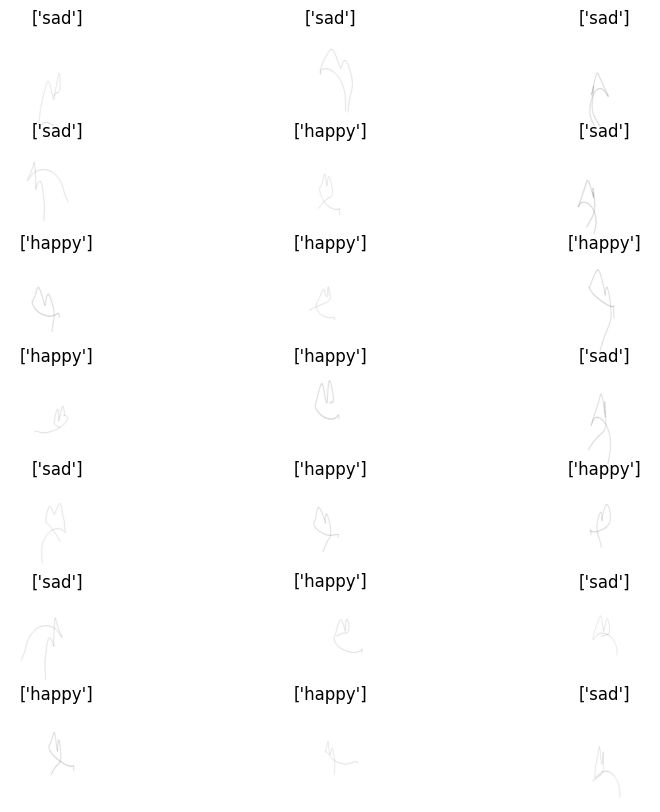

Feature batch shape: torch.Size([26, 3, 224, 224])
Labels batch shape: torch.Size([26])


In [ ]:
# Showing some images
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 7
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item() # can change dataset here
    img, label = train_dataset[sample_idx] # then also change this
    figure.add_subplot(rows, cols, i)
    plt.title([classes[label.item()]])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


# Training, Validation and Visualization

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25, patience = 5):
   since = time.time()
   # Initialize empty lists to store training and validation metrics
   train_loss_history = []
   counter = 0
   best_val_loss = float('inf') # Early dropout best value

   #Epoch loop
   for epoch in range(num_epochs):
       print('Epoch {}/{}'.format(epoch, num_epochs - 1))
       print('-' * 10)

       running_loss = 0.0
       train_loss = 0

       # Iterate over data.
       for i, data in enumerate(train_loader):
           inputs , labels = data
           inputs = inputs.to(device)
           labels = labels.to(device)

           optimizer.zero_grad()

           with torch.set_grad_enabled(True):
               outputs  = model(inputs)
               loss = criterion(outputs, labels)

           loss.backward()
           optimizer.step()

           train_loss += loss.item() * inputs.size(0)
           running_loss += loss.item()
           print('{} Loss: {:.4f}'.format('train', loss.item()))

       avg_loss = running_loss / len(train_loader)
       train_loss_history.append(avg_loss)
       print('Average epoch loss: ', avg_loss)



   time_elapsed = time.time() - since
   print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

   return model, train_loss_history

In [ ]:
# Function to evaluate the model on the validation set
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Calc loss and if label is correct
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            #print(correct_predictions)
            #print(predicted)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

In [ ]:
# Visualize some of the model prediction
def visualize_model(model, data_loader, num_images=6):
   was_training = model.training
   model.eval()
   images_so_far = 0
   fig = plt.figure()

   with torch.no_grad():
       for inputs, labels in data_loader:
           inputs = inputs.to(device)
           labels = labels.to(device)
           #print(inputs.shape)
           outputs = model(inputs)
           _, preds = torch.max(outputs, 1)

          #Plots
           for j in range(inputs.size()[0]):
               images_so_far += 1
               ax = plt.subplot(num_images//2, 2, images_so_far)
               ax.axis('off')
               ax.set_title('predicted: {} truth: {}'.format(classes[preds[j].item()], classes[labels[j].item()]))
               img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
               #img = std * img + mean
               ax.imshow(img)

               if images_so_far == num_images:
                   model.train(mode=was_training)
                   return
       model.train(mode=was_training)

# Transfer Models

In [ ]:
## Load the model based on VGG19
vgg_based = torchvision.models.vgg19(pretrained=True)

## freeze the layers
for param in vgg_based.parameters():
   param.requires_grad = False

# Modify the last layer
number_features = vgg_based.classifier[6].in_features
features = list(vgg_based.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, 2)])
vgg_based.classifier = torch.nn.Sequential(*features)

vgg_based = vgg_based.to(device)

print(vgg_based)

criterion = torch.nn.CrossEntropyLoss() # Loss function
optimizer_ft_vgg = optim.Adam(vgg_based.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
## Load the model based on Resnet18
res_based = torchvision.models.resnet18(pretrained=True)

# Freeze the layers
for param in res_based.parameters():
    param.requires_grad = False

# Modify the last layer for transfer learning
num_classes = 2  # Replace with the number of classes in your new task
number_features = res_based.fc.in_features

# Replace the last layer with a new fully connected layer
res_based.fc = torch.nn.Linear(number_features, num_classes)

# Print the modified model
print(res_based)

res_based = res_based.to(device)

print("Freezed Model Resnet18 with 2 Output Layer Untrained ",res_based)

criterion = torch.nn.CrossEntropyLoss()
optimizer_ft_res = optim.Adam(res_based.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# ResNet18 Training

In [ ]:
res_based, loss_history_res = train_model(res_based, criterion, optimizer_ft_res, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8609
train Loss: 0.6584
train Loss: 0.8189
train Loss: 0.6364
train Loss: 0.6947
train Loss: 0.6129
train Loss: 0.6027
train Loss: 0.6599
Average epoch loss:  0.6931147873401642
Epoch 1/24
----------
train Loss: 0.5693
train Loss: 0.7525
train Loss: 0.6576
train Loss: 0.5411
train Loss: 0.5721
train Loss: 0.5027
train Loss: 0.5040
train Loss: 0.5095
Average epoch loss:  0.5761049389839172
Epoch 2/24
----------
train Loss: 0.3883
train Loss: 0.4656
train Loss: 0.4079
train Loss: 0.4100
train Loss: 0.3839
train Loss: 0.5128
train Loss: 0.4294
train Loss: 0.3804
Average epoch loss:  0.42228963971138
Epoch 3/24
----------
train Loss: 0.3388
train Loss: 0.2969
train Loss: 0.4110
train Loss: 0.3759
train Loss: 0.4152
train Loss: 0.3340
train Loss: 0.3482
train Loss: 0.3275
Average epoch loss:  0.3559156283736229
Epoch 4/24
----------
train Loss: 0.3043
train Loss: 0.3375
train Loss: 0.2838
train Loss: 0.2704
train Loss: 0.2601
train Loss: 0.4462
train Loss

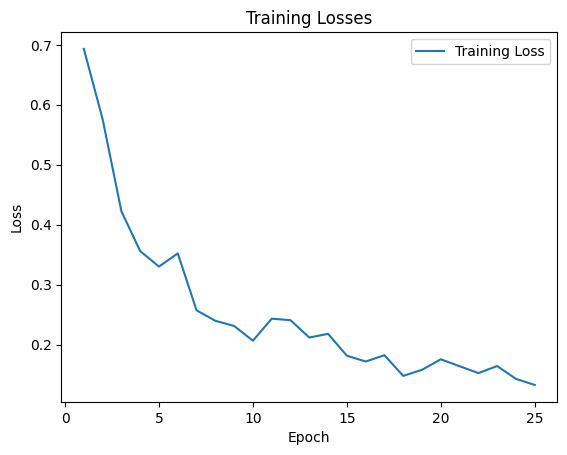

In [ ]:
# Plot training and validation losses
plt.figure()
plt.plot(range(1, len(loss_history_res) + 1), loss_history_res, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

In [ ]:
avg_loss, acc = validate(res_based, train_loader,criterion, device)
print("\nAvg Loss: ",avg_loss," Accuracy: ", acc*100,"%")

Validation: 100%|██████████| 8/8 [00:15<00:00,  1.88s/it]


Avg Loss:  0.12162631936371326  Accuracy:  97.5 %


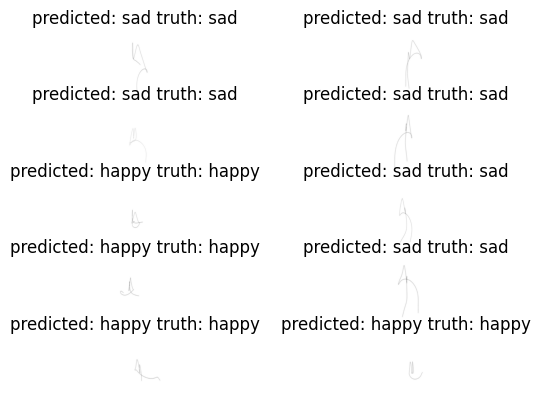

In [ ]:
visualize_model(res_based, test_loader,10)
plt.show()

# VGG19 Training

In [ ]:
vgg_based, loss_history = train_model(vgg_based, criterion, optimizer_ft_vgg, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6766
train Loss: 0.6067
train Loss: 0.8029
train Loss: 0.6562
train Loss: 0.4939
train Loss: 0.4659
train Loss: 0.4986
train Loss: 0.5523
Average epoch loss:  0.5941370166838169
Epoch 1/24
----------
train Loss: 0.4924
train Loss: 0.4273
train Loss: 0.4632
train Loss: 0.4236
train Loss: 0.4184
train Loss: 0.4493
train Loss: 0.3171
train Loss: 0.3302
Average epoch loss:  0.41519851982593536
Epoch 2/24
----------
train Loss: 0.3299
train Loss: 0.3735
train Loss: 0.3668
train Loss: 0.3735
train Loss: 0.4199
train Loss: 0.3082
train Loss: 0.2707
train Loss: 0.2669
Average epoch loss:  0.3386818394064903
Epoch 3/24
----------
train Loss: 0.3095
train Loss: 0.3184
train Loss: 0.2553
train Loss: 0.4242
train Loss: 0.2533
train Loss: 0.2605
train Loss: 0.3654
train Loss: 0.4933
Average epoch loss:  0.3349740579724312
Epoch 4/24
----------
train Loss: 0.3849
train Loss: 0.3730
train Loss: 0.3039
train Loss: 0.3304
train Loss: 0.2870
train Loss: 0.2295
train L

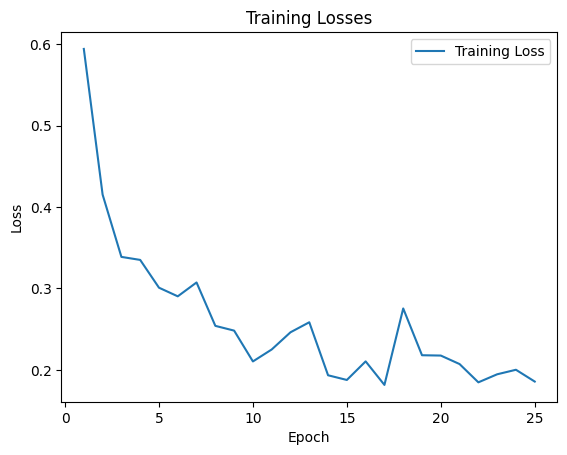

In [ ]:
# Plot training and validation losses
plt.figure()
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

In [ ]:
avg_loss, acc = validate(vgg_based, test_loader,criterion, device)
print("\nAvg Loss: ",avg_loss," Accuracy on Test: ", acc*100,"%")

Validation: 100%|██████████| 8/8 [00:43<00:00,  5.47s/it]


Avg Loss:  0.18617354705929756  Accuracy on Test:  96.25 %


In [ ]:
avg_loss, acc = validate(vgg_based, train_loader,criterion, device)
print("\nAvg Loss: ",avg_loss," Accuracy on Training: ", acc*100,"%")

Validation: 100%|██████████| 8/8 [01:51<00:00, 13.96s/it]


Avg Loss:  0.1419693948701024  Accuracy on Training:  97.0 %


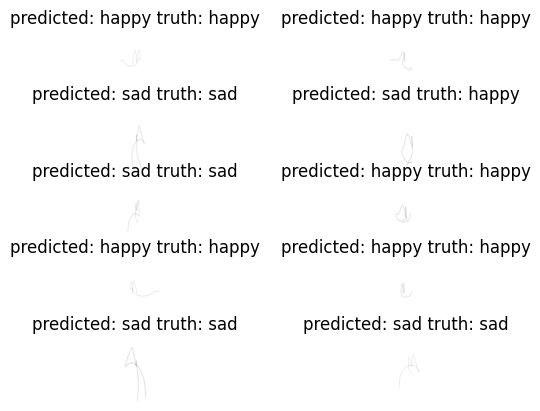

In [ ]:
visualize_model(vgg_based, test_loader, 10)
plt.show()

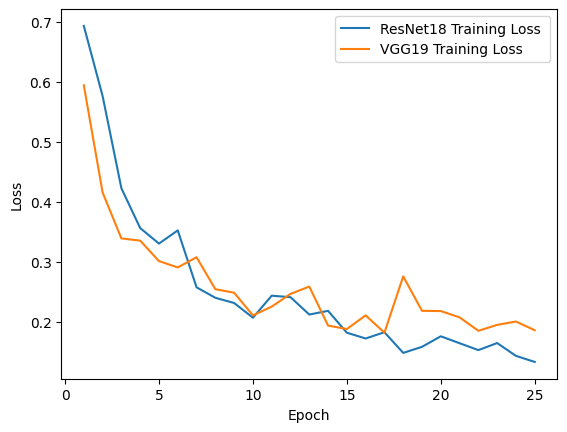

In [31]:
# Plot training losses
plt.figure()
plt.plot(range(1, len(loss_history_res) + 1), loss_history_res, label='ResNet18 Training Loss ')
plt.plot(range(1, len(loss_history) + 1), loss_history, label='VGG19 Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.title('Training Losses')
plt.legend()
plt.savefig('/content/drive/MyDrive/Images/TrainingLoss_Res_VGG.png', dpi=300)

plt.show()

